On perlmutter: use kernel pytorch-1.13.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pickle
plt.style.use("../science.mplstyle")

import os
import torch

from numba import cuda 

from helpers.plotting import *
from helpers.evaluation import *
from helpers.data_transforms import clean_data



In [2]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"

flow_id = "double_1"
particle_type = "upsilon_iso"

project_id = f"lowmass_{particle_type}_nojet"
config_id = "CATHODE_8"

flow_training_dir = os.path.join(f"{working_dir}/models", f"{project_id}/{flow_id}/{config_id}")
#
seeds_list = [1, 2, 3, 4]
data_dict = {'SBL':[], 'SBH':[], 'SB':[], 'SBL_samples':[], 'SBH_samples':[], 'SB_samples':[]}



for seed in seeds_list:
    path_to_samples = f"{flow_training_dir}/flow_samples_seed{seed}"
    with open(path_to_samples, "rb") as infile: 
        loc_data_dict = pickle.load(infile)
        for key in data_dict.keys():
            if "samples" in key or seed == 1:
                data_dict[key].append(loc_data_dict[key])
            
for key in data_dict.keys():
    data_dict[key] = np.vstack(data_dict[key])
    print(key, data_dict[key].shape)

    
    
    
with open(f"{flow_training_dir}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(feature_set)


SBL (78048, 3)
SBH (238192, 3)
SB (316240, 3)
SBL_samples (312192, 3)
SBH_samples (952768, 3)
SB_samples (1264960, 3)
['dimu_pt', 'dimu_eta', 'dimu_mass']


## Evaluate the SB Samples

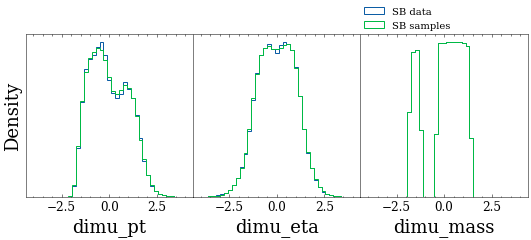

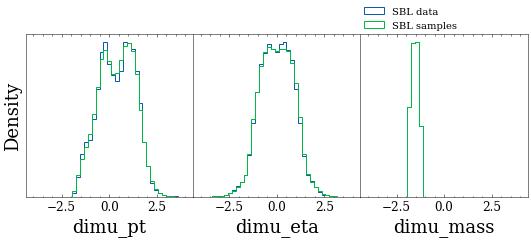

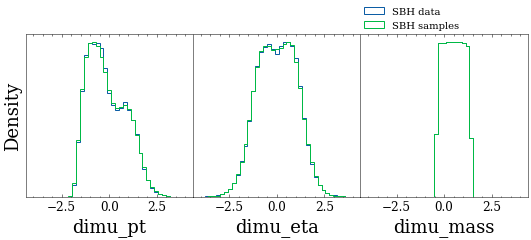

In [3]:
plot_bound = 4
log_scale = False


#data_dict["SR_samples"] = clean_data(data_dict["SR_samples"])
data_dict["SBL_samples"] = clean_data(data_dict["SBL_samples"])
data_dict["SBH_samples"] = clean_data(data_dict["SBH_samples"])

#hist_all_features_array([data_dict["SR"], data_dict["SR_samples"]], ["SR data", "SR samples"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SB"], data_dict["SB_samples"]], ["SB data", "SB samples"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SBL"], data_dict["SBL_samples"]], ["SBL data", "SBL samples"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)
hist_all_features_array([data_dict["SBH"], data_dict["SBH_samples"]], ["SBH data", "SBH samples"], feature_set, plot_bound = plot_bound, yscale_log = log_scale)


# Fancier things below

Wasserstein distance

In [4]:
from scipy.stats import ks_2samp
#wds = get_1d_wasserstein_distances(data_dict["SB"], data_dict["SB_samples"])

def get_dist(samp0, samp1):
    
    
    divs = []
    
    for i in range(samp0.shape[1]):
        divs.append(ks_2samp(samp0[:,i], samp1[:,i])[0])
    return divs

wds = get_dist(data_dict["SB"], data_dict["SB_samples"])


for i, wd in enumerate(wds):
    print(f"Feature {i} KL div: {wd}")
print(f"Total distance: {np.mean(wds)}")


"""

wds = get_1d_wasserstein_distances(np.random.normal(size = data_dict["SB"].shape), np.random.normal(size = data_dict["SB"].shape))


for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")
"""



Feature 0 KL div: 0.004729793827472795
Feature 1 KL div: 0.001866462180622308
Feature 2 KL div: 0.0
Total distance: 0.0021987520026983676


'\n\nwds = get_1d_wasserstein_distances(np.random.normal(size = data_dict["SB"].shape), np.random.normal(size = data_dict["SB"].shape))\n\n\nfor i, wd in enumerate(wds):\n    print(f"Feature {i} distance: {wd}")\nprint(f"Total distance: {np.mean(wds)}")\n'

Binary classifier

In [5]:
n_estimators = 100 # number of boosting stages
max_depth = 20 # max depth of individual regression estimators; related to complexity
learning_rate = 0.1
subsample = 0.5 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 10 # stop training BDT is validation loss doesn't improve after this many rounds


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import xgboost as xgb

0


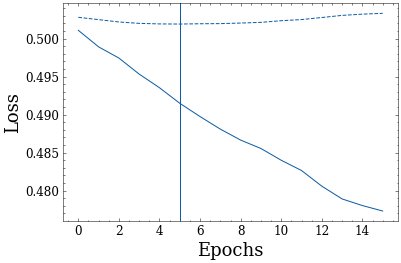

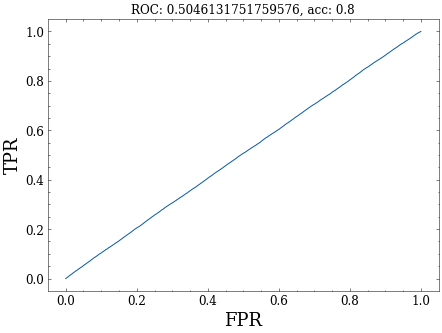


1


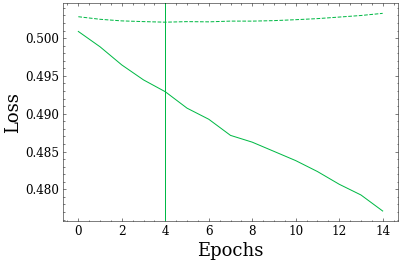

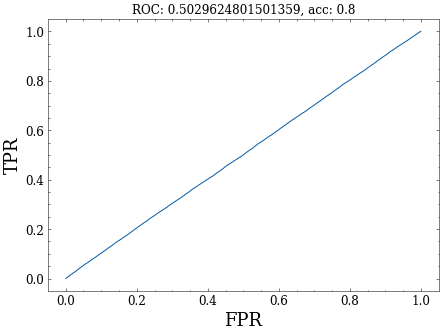


2


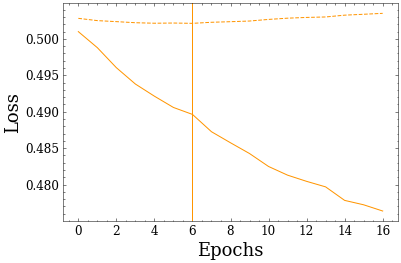

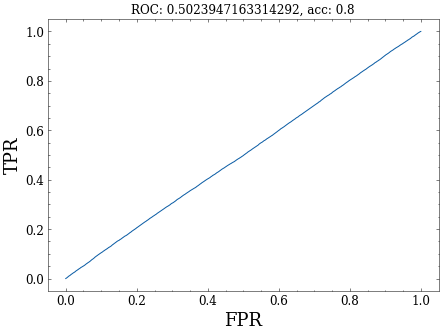


0.5033234572191742 0.0009409634227730742
[0.5046131751759576, 0.5029624801501359, 0.5023947163314292]


In [6]:


SB_data_train, SB_data_test = train_test_split(data_dict["SB"], test_size=0.1, random_state=42)
SB_samples_train, SB_samples_test = train_test_split(data_dict["SB_samples"], test_size=0.1, random_state=42)


SB_samples_train = clean_data(SB_samples_train)
SB_samples_test = clean_data(SB_samples_test)

X_train = np.vstack([SB_data_train, SB_samples_train])

Y_train = np.vstack([np.ones((SB_data_train.shape[0], 1)), np.zeros((SB_samples_train.shape[0], 1))])

X_val = np.vstack([SB_data_test, SB_samples_test])
Y_val = np.vstack([np.ones((SB_data_test.shape[0], 1)), np.zeros((SB_samples_test.shape[0], 1))])

n_runs = 3
auc_list = []
acc_list = []




for i in range(n_runs):
    
    print(i)

    

    eval_set = [(X_train, Y_train), (X_val, Y_val)]

    bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = i, eval_metric="logloss")

    bst_i.fit(X_train, Y_train,  eval_set=eval_set,   verbose=False)
    results_f = bst_i.evals_result()
    losses = results_f["validation_0"]["logloss"]
    losses_val = results_f["validation_1"]["logloss"]
    best_epoch = bst_i.best_iteration
    
    plt.figure()
    plt.plot(losses, color = f"C{i}")
    plt.plot(losses_val, color = f"C{i}", linestyle = "dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color = f"C{i}")
    plt.show()

    loc_scores =  bst_i.predict_proba(X_val, iteration_range=(0,bst_i.best_iteration))[:,1]

    loc_auc = roc_auc_score(Y_val, loc_scores)
    loc_acc = accuracy_score(Y_val, np.round(loc_scores))
    fpr, tpr, _ = roc_curve(Y_val, loc_scores)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(f"ROC: {loc_auc}, acc: {loc_acc}")
    plt.show()
    
    auc_list.append(loc_auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


0


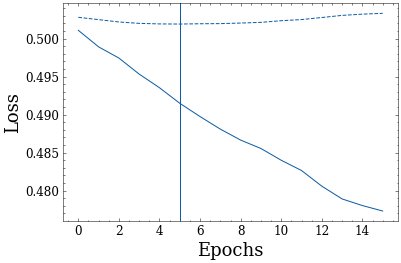

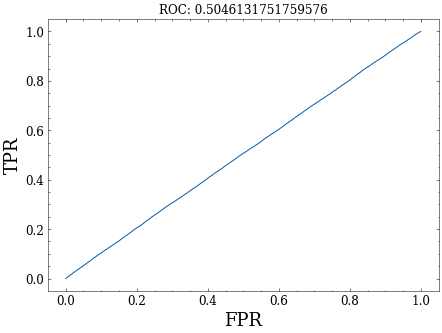


1


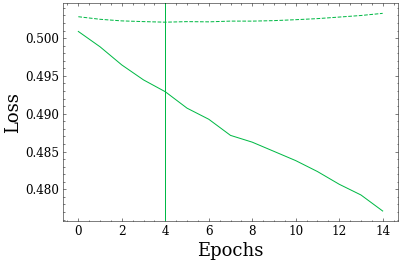

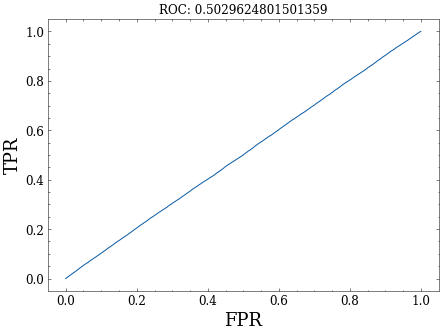


2


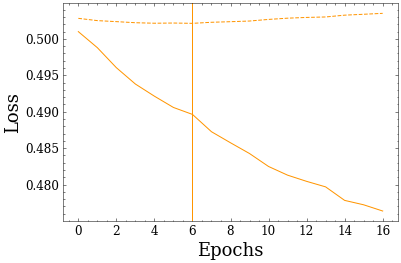

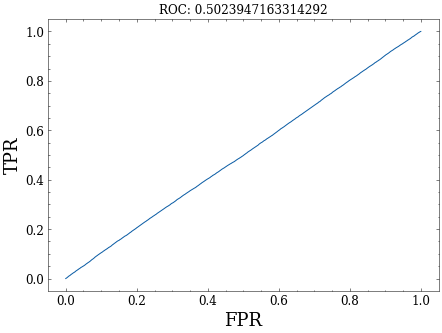


0.5033234572191742 0.0009409634227730742
[0.5046131751759576, 0.5029624801501359, 0.5023947163314292]


In [8]:


SB_data_train, SB_data_test = train_test_split(data_dict["SB"], test_size=0.1, random_state=42)
SB_samples_train, SB_samples_test = train_test_split(data_dict["SB_samples"], test_size=0.1, random_state=42)

X_train = np.vstack([SB_data_train, SB_samples_train])
Y_train = np.vstack([np.ones((SB_data_train.shape[0], 1)), np.zeros((SB_samples_train.shape[0], 1))])

X_val = np.vstack([SB_data_test, SB_samples_test])
Y_val = np.vstack([np.ones((SB_data_test.shape[0], 1)), np.zeros((SB_samples_test.shape[0], 1))])

n_runs = 3
auc_list = []


for i in range(n_runs):
    
    print(i)

    

    eval_set = [(X_train, Y_train), (X_val, Y_val)]

    bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = i, eval_metric="logloss")

    bst_i.fit(X_train, Y_train,  eval_set=eval_set,   verbose=False)
    results_f = bst_i.evals_result()
    losses = results_f["validation_0"]["logloss"]
    losses_val = results_f["validation_1"]["logloss"]
    best_epoch = bst_i.best_iteration
    
    plt.figure()
    plt.plot(losses, color = f"C{i}")
    plt.plot(losses_val, color = f"C{i}", linestyle = "dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color = f"C{i}")
    plt.show()

    loc_scores =  bst_i.predict_proba(X_val, iteration_range=(0,bst_i.best_iteration))[:,1]

    loc_auc = roc_auc_score(Y_val, loc_scores)
    fpr, tpr, _ = roc_curve(Y_val, loc_scores)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(loc_auc))
    plt.show()
    
    auc_list.append(loc_auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


In [9]:



SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SBH"], data_dict["SBH_samples"], 
                                                                                  test_size=0.1, random_state=42)

X_train = np.vstack([SB_data_train, SB_samples_train])
Y_train = np.vstack([np.ones((SB_data_train.shape[0], 1)), np.zeros((SB_samples_train.shape[0], 1))])

X_val = np.vstack([SB_data_test, SB_samples_test])
Y_val = np.vstack([np.ones((SB_data_test.shape[0], 1)), np.zeros((SB_samples_test.shape[0], 1))])

n_runs = 3
auc_list = []


for i in range(n_runs):
    
    print(i)

    

    eval_set = [(X_train, Y_train), (X_val, Y_val)]

    bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = i, eval_metric="logloss")

    bst_i.fit(X_train, Y_train,  eval_set=eval_set,   verbose=False)
    results_f = bst_i.evals_result()
    losses = results_f["validation_0"]["logloss"]
    losses_val = results_f["validation_1"]["logloss"]
    best_epoch = bst_i.best_iteration
    
    plt.figure()
    plt.plot(losses, color = f"C{i}")
    plt.plot(losses_val, color = f"C{i}", linestyle = "dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.axvline(best_epoch, color = f"C{i}")
    plt.show()

    loc_scores =  bst_i.predict_proba(X_val, iteration_range=(0,bst_i.best_iteration))[:,1]

    loc_auc = roc_auc_score(Y_val, loc_scores)
    fpr, tpr, _ = roc_curve(Y_val, loc_scores)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(loc_auc))
    plt.show()
    
    auc_list.append(loc_auc)
    
    print()

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)


ValueError: Found input variables with inconsistent numbers of samples: [238192, 952768]

## 